# Examples of usage of spatial weights

Spatial weights are used across `momepy`. This notebook will illustrate its use on three examples.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [2]:
import osmnx as ox

gdf = ox.footprints.footprints_from_place(place='Kahla, Germany')
gdf_projected = ox.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Loop 1 out of 2.


Identifying changes:   0%|          | 0/2932 [00:00<?, ?it/s]

Identifying changes:  15%|█▍        | 428/2932 [00:00<00:00, 4264.40it/s]

Identifying changes:  30%|██▉       | 878/2932 [00:00<00:00, 4331.90it/s]

Identifying changes:  44%|████▍     | 1295/2932 [00:00<00:00, 4281.42it/s]

Identifying changes:  59%|█████▉    | 1732/2932 [00:00<00:00, 4306.70it/s]

Identifying changes:  75%|███████▍  | 2195/2932 [00:00<00:00, 4397.31it/s]

Identifying changes:  94%|█████████▍| 2763/2932 [00:00<00:00, 4716.00it/s]

Identifying changes: 100%|██████████| 2932/2932 [00:00<00:00, 4565.96it/s]


Changing geometry:   0%|          | 0/31 [00:00<?, ?it/s]

Changing geometry:  29%|██▉       | 9/31 [00:00<00:00, 88.03it/s]

Changing geometry:  55%|█████▍    | 17/31 [00:00<00:00, 82.83it/s]

Changing geometry:  87%|████████▋ | 27/31 [00:00<00:00, 86.62it/s]

Changing geometry: 100%|██████████| 31/31 [00:00<00:00, 86.30it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/2520 [00:00<?, ?it/s]

Identifying changes:  17%|█▋        | 430/2520 [00:00<00:00, 4295.22it/s]

Identifying changes:  35%|███▌      | 885/2520 [00:00<00:00, 4367.70it/s]

Identifying changes:  50%|████▉     | 1250/2520 [00:00<00:00, 4113.87it/s]

Identifying changes:  69%|██████▉   | 1740/2520 [00:00<00:00, 4321.86it/s]

Identifying changes:  90%|█████████ | 2276/2520 [00:00<00:00, 4587.49it/s]

Identifying changes: 100%|██████████| 2520/2520 [00:00<00:00, 4520.50it/s]


Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Changing geometry: 100%|██████████| 2/2 [00:00<00:00, 84.03it/s]

Inward offset...
Discretization...


  0%|          | 0/2521 [00:00<?, ?it/s]

  1%|▏         | 33/2521 [00:00<00:07, 321.42it/s]

Generating input point array...


  2%|▏         | 58/2521 [00:00<00:08, 274.80it/s]

  4%|▍         | 98/2521 [00:00<00:08, 302.05it/s]

  5%|▌         | 133/2521 [00:00<00:07, 306.97it/s]

  7%|▋         | 180/2521 [00:00<00:06, 341.48it/s]

 10%|▉         | 245/2521 [00:00<00:05, 396.74it/s]

 12%|█▏        | 307/2521 [00:00<00:04, 443.83it/s]

 14%|█▍        | 354/2521 [00:00<00:04, 444.59it/s]

 16%|█▋        | 411/2521 [00:00<00:04, 474.10it/s]

 19%|█▉        | 485/2521 [00:01<00:03, 530.48it/s]

 22%|██▏       | 562/2521 [00:01<00:03, 584.56it/s]

 25%|██▌       | 632/2521 [00:01<00:03, 614.83it/s]

 29%|██▉       | 741/2521 [00:01<00:02, 707.01it/s]

 32%|███▏      | 819/2521 [00:01<00:02, 577.25it/s]

 36%|███▌      | 902/2521 [00:01<00:02, 634.26it/s]

 39%|███▊      | 974/2521 [00:01<00:02, 652.70it/s]

 42%|████▏     | 1055/2521 [00:01<00:02, 691.16it/s]

 45%|████▍     | 1129/2521 [00:01<00:02, 648.08it/s]

 48%|████▊     | 1214/2521 [00:02<00:01, 695.67it/s]

 51%|█████     | 1288/2521 [00:02<00:01, 705.72it/s]

 54%|█████▍    | 1362/2521 [00:02<00:01, 682.83it/s]

 57%|█████▋    | 1433/2521 [00:02<00:01, 638.89it/s]

 61%|██████    | 1533/2521 [00:02<00:01, 716.34it/s]

 65%|██████▌   | 1641/2521 [00:02<00:01, 794.29it/s]

 69%|██████▊   | 1727/2521 [00:02<00:01, 664.41it/s]

 72%|███████▏  | 1807/2521 [00:02<00:01, 698.29it/s]

 75%|███████▍  | 1883/2521 [00:03<00:00, 712.55it/s]

 78%|███████▊  | 1967/2521 [00:03<00:00, 746.53it/s]

 81%|████████  | 2046/2521 [00:03<00:00, 756.70it/s]

 85%|████████▍ | 2131/2521 [00:03<00:00, 781.84it/s]

 89%|████████▉ | 2242/2521 [00:03<00:00, 853.03it/s]

 92%|█████████▏| 2331/2521 [00:03<00:00, 836.07it/s]

 96%|█████████▌| 2417/2521 [00:03<00:00, 787.60it/s]

 99%|█████████▉| 2506/2521 [00:03<00:00, 809.47it/s]

100%|██████████| 2521/2521 [00:03<00:00, 666.82it/s]

Generating Voronoi diagram...


Generating GeoDataFrame...


Vertices to Polygons:   0%|          | 0/267595 [00:00<?, ?it/s]

Vertices to Polygons:   1%|          | 3003/267595 [00:00<00:08, 30027.24it/s]

Vertices to Polygons:   3%|▎         | 7130/267595 [00:00<00:07, 32699.25it/s]

Vertices to Polygons:   4%|▍         | 11202/267595 [00:00<00:07, 34751.70it/s]

Vertices to Polygons:   6%|▌         | 15259/267595 [00:00<00:10, 24168.87it/s]

Vertices to Polygons:   7%|▋         | 18971/267595 [00:00<00:09, 26993.06it/s]

Vertices to Polygons:   9%|▊         | 23011/267595 [00:00<00:08, 29976.66it/s]

Vertices to Polygons:  10%|█         | 27230/267595 [00:00<00:07, 32825.98it/s]

Vertices to Polygons:  12%|█▏        | 31445/267595 [00:00<00:06, 35159.08it/s]

Vertices to Polygons:  13%|█▎        | 35098/267595 [00:01<00:07, 32262.77it/s]

Vertices to Polygons:  14%|█▍        | 38467/267595 [00:01<00:07, 32601.55it/s]

Vertices to Polygons:  16%|█▌        | 42773/267595 [00:01<00:06, 35162.52it/s]

Vertices to Polygons:  17%|█▋        | 46545/267595 [00:01<00:06, 35891.04it/s]

Vertices to Polygons:  19%|█▉        | 50228/267595 [00:01<00:06, 35197.30it/s]

Vertices to Polygons:  20%|██        | 53926/267595 [00:01<00:05, 35712.65it/s]

Vertices to Polygons:  22%|██▏       | 58115/267595 [00:01<00:05, 37363.71it/s]

Vertices to Polygons:  23%|██▎       | 62541/267595 [00:01<00:05, 39195.66it/s]

Vertices to Polygons:  25%|██▍       | 66632/267595 [00:01<00:05, 39694.34it/s]

Vertices to Polygons:  26%|██▋       | 70661/267595 [00:02<00:04, 39870.01it/s]

Vertices to Polygons:  28%|██▊       | 74680/267595 [00:02<00:04, 39403.44it/s]

Vertices to Polygons:  29%|██▉       | 78720/267595 [00:02<00:04, 39679.18it/s]

Vertices to Polygons:  31%|███       | 82705/267595 [00:02<00:04, 39467.16it/s]

Vertices to Polygons:  32%|███▏      | 86871/267595 [00:02<00:04, 40098.33it/s]

Vertices to Polygons:  34%|███▍      | 90892/267595 [00:02<00:04, 39631.97it/s]

Vertices to Polygons:  35%|███▌      | 94865/267595 [00:02<00:04, 36699.51it/s]

Vertices to Polygons:  37%|███▋      | 98585/267595 [00:02<00:04, 35972.54it/s]

Vertices to Polygons:  38%|███▊      | 102386/267595 [00:02<00:04, 36560.18it/s]

Vertices to Polygons:  40%|███▉      | 106351/267595 [00:02<00:04, 37432.91it/s]

Vertices to Polygons:  41%|████      | 110338/267595 [00:03<00:04, 38132.15it/s]

Vertices to Polygons:  43%|████▎     | 114173/267595 [00:03<00:04, 37510.95it/s]

Vertices to Polygons:  44%|████▍     | 117941/267595 [00:03<00:04, 35404.31it/s]

Vertices to Polygons:  45%|████▌     | 121518/267595 [00:03<00:04, 32601.87it/s]

Vertices to Polygons:  47%|████▋     | 125351/267595 [00:03<00:04, 34131.29it/s]

Vertices to Polygons:  48%|████▊     | 129386/267595 [00:03<00:03, 35785.11it/s]

Vertices to Polygons:  50%|████▉     | 133217/267595 [00:03<00:03, 36502.96it/s]

Vertices to Polygons:  51%|█████     | 136919/267595 [00:03<00:03, 35381.63it/s]

Vertices to Polygons:  53%|█████▎    | 140501/267595 [00:03<00:03, 35331.91it/s]

Vertices to Polygons:  54%|█████▍    | 144065/267595 [00:04<00:04, 24926.05it/s]

Vertices to Polygons:  55%|█████▌    | 147357/267595 [00:04<00:04, 26883.89it/s]

Vertices to Polygons:  56%|█████▌    | 150401/267595 [00:04<00:04, 26869.55it/s]

Vertices to Polygons:  57%|█████▋    | 153666/267595 [00:04<00:04, 28375.70it/s]

Vertices to Polygons:  59%|█████▊    | 156701/267595 [00:04<00:04, 27623.27it/s]

Vertices to Polygons:  60%|█████▉    | 159606/267595 [00:04<00:04, 26349.27it/s]

Vertices to Polygons:  61%|██████    | 162353/267595 [00:04<00:04, 21737.22it/s]

Vertices to Polygons:  62%|██████▏   | 164739/267595 [00:05<00:04, 22230.62it/s]

Vertices to Polygons:  62%|██████▏   | 167114/267595 [00:05<00:04, 22573.14it/s]

Vertices to Polygons:  64%|██████▎   | 170138/267595 [00:05<00:03, 24428.72it/s]

Vertices to Polygons:  65%|██████▍   | 173329/267595 [00:05<00:03, 26276.00it/s]

Vertices to Polygons:  66%|██████▌   | 176617/267595 [00:05<00:03, 27959.81it/s]

Vertices to Polygons:  67%|██████▋   | 179881/267595 [00:05<00:03, 29205.22it/s]

Vertices to Polygons:  68%|██████▊   | 182897/267595 [00:05<00:02, 28884.80it/s]

Vertices to Polygons:  70%|██████▉   | 186262/267595 [00:05<00:02, 30165.05it/s]

Vertices to Polygons:  71%|███████   | 189341/267595 [00:05<00:02, 29915.68it/s]

Vertices to Polygons:  72%|███████▏  | 192438/267595 [00:05<00:02, 30224.30it/s]

Vertices to Polygons:  73%|███████▎  | 195492/267595 [00:06<00:02, 28418.81it/s]

Vertices to Polygons:  74%|███████▍  | 198806/267595 [00:06<00:02, 29686.50it/s]

Vertices to Polygons:  76%|███████▌  | 202835/267595 [00:06<00:02, 32230.66it/s]

Vertices to Polygons:  77%|███████▋  | 206914/267595 [00:06<00:01, 34395.31it/s]

Vertices to Polygons:  79%|███████▉  | 211124/267595 [00:06<00:01, 36388.43it/s]

Vertices to Polygons:  80%|████████  | 214931/267595 [00:06<00:01, 36876.46it/s]

Vertices to Polygons:  82%|████████▏ | 218839/267595 [00:06<00:01, 37509.27it/s]

Vertices to Polygons:  83%|████████▎ | 222670/267595 [00:06<00:01, 37745.72it/s]

Vertices to Polygons:  85%|████████▍ | 226484/267595 [00:06<00:01, 37859.29it/s]

Vertices to Polygons:  86%|████████▌ | 230406/267595 [00:06<00:00, 38256.02it/s]

Vertices to Polygons:  88%|████████▊ | 234252/267595 [00:07<00:00, 38054.26it/s]

Vertices to Polygons:  89%|████████▉ | 238072/267595 [00:07<00:00, 37680.95it/s]

Vertices to Polygons:  91%|█████████ | 242225/267595 [00:07<00:00, 38757.32it/s]

Vertices to Polygons:  92%|█████████▏| 246244/267595 [00:07<00:00, 39175.45it/s]

Vertices to Polygons:  94%|█████████▎| 250446/267595 [00:07<00:00, 39987.33it/s]

Vertices to Polygons:  95%|█████████▌| 254458/267595 [00:07<00:00, 39878.53it/s]

Vertices to Polygons:  97%|█████████▋| 258455/267595 [00:07<00:00, 39471.47it/s]

Vertices to Polygons:  98%|█████████▊| 262617/267595 [00:07<00:00, 40091.77it/s]

Vertices to Polygons: 100%|█████████▉| 266634/267595 [00:07<00:00, 39129.23it/s]

Vertices to Polygons: 100%|██████████| 267595/267595 [00:07<00:00, 33889.31it/s]

Dissolving Voronoi polygons...


Preparing limit for edge resolving...


Building R-tree...


  0%|          | 0/371 [00:00<?, ?it/s]

  9%|▉         | 33/371 [00:00<00:01, 323.12it/s]

Identifying edge cells...


 13%|█▎        | 49/371 [00:00<00:01, 241.74it/s]

 16%|█▋        | 61/371 [00:00<00:01, 184.66it/s]

 22%|██▏       | 82/371 [00:00<00:01, 190.58it/s]

 30%|██▉       | 111/371 [00:00<00:01, 212.41it/s]

 39%|███▉      | 145/371 [00:00<00:00, 238.13it/s]

 46%|████▌     | 169/371 [00:00<00:01, 196.59it/s]

 51%|█████▏    | 191/371 [00:00<00:00, 201.40it/s]

 58%|█████▊    | 215/371 [00:00<00:00, 210.68it/s]

 64%|██████▍   | 237/371 [00:01<00:00, 203.62it/s]

 70%|██████▉   | 258/371 [00:01<00:00, 178.63it/s]

 75%|███████▌  | 280/371 [00:01<00:00, 188.18it/s]

 83%|████████▎ | 308/371 [00:01<00:00, 207.06it/s]

 90%|█████████ | 334/371 [00:01<00:00, 219.02it/s]

 97%|█████████▋| 361/371 [00:01<00:00, 231.80it/s]

100%|██████████| 371/371 [00:01<00:00, 216.81it/s]


  0%|          | 0/238 [00:00<?, ?it/s]

 15%|█▍        | 35/238 [00:00<00:00, 346.75it/s]

Cutting...


 32%|███▏      | 76/238 [00:00<00:00, 362.81it/s]

 50%|████▉     | 118/238 [00:00<00:00, 376.74it/s]

 71%|███████   | 168/238 [00:00<00:00, 405.36it/s]

 87%|████████▋ | 208/238 [00:00<00:00, 402.84it/s]

100%|██████████| 238/238 [00:00<00:00, 419.56it/s]

## First order contiguity

### Distance to neighbours

To calculate the mean distance to neighbouring buildings, we need queen contiguity weights of the first order capturing the relationship between immediate neighbours. Relationship between buildings is here represented by relationships between their tessellation cells.

In [3]:
sw1 = momepy.sw_high(k=1, gdf=tessellation, ids='uID')

In [4]:
buildings['neighbour_dist'] = momepy.NeighborDistance(buildings, sw1, 'uID').series

  0%|          | 0/2518 [00:00<?, ?it/s]

  2%|▏         | 60/2518 [00:00<00:04, 596.83it/s]

  4%|▎         | 93/2518 [00:00<00:05, 478.13it/s]

  6%|▌         | 154/2518 [00:00<00:04, 509.96it/s]

  9%|▉         | 221/2518 [00:00<00:04, 548.86it/s]

 12%|█▏        | 292/2518 [00:00<00:03, 588.26it/s]

 14%|█▍        | 364/2518 [00:00<00:03, 620.86it/s]

 17%|█▋        | 434/2518 [00:00<00:03, 642.43it/s]

 20%|██        | 505/2518 [00:00<00:03, 660.75it/s]

 23%|██▎       | 570/2518 [00:00<00:03, 630.80it/s]

 25%|██▌       | 634/2518 [00:01<00:02, 629.76it/s]

 28%|██▊       | 702/2518 [00:01<00:02, 643.35it/s]

 31%|███       | 773/2518 [00:01<00:02, 660.66it/s]

 34%|███▍      | 852/2518 [00:01<00:02, 692.02it/s]

 37%|███▋      | 922/2518 [00:01<00:02, 666.12it/s]

 39%|███▉      | 993/2518 [00:01<00:02, 677.25it/s]

 42%|████▏     | 1062/2518 [00:01<00:02, 652.05it/s]

 45%|████▍     | 1128/2518 [00:01<00:02, 633.60it/s]

 47%|████▋     | 1192/2518 [00:01<00:02, 521.32it/s]

 50%|████▉     | 1248/2518 [00:02<00:02, 473.19it/s]

 52%|█████▏    | 1299/2518 [00:02<00:03, 397.31it/s]

 53%|█████▎    | 1344/2518 [00:02<00:03, 332.35it/s]

 55%|█████▌    | 1391/2518 [00:02<00:03, 361.78it/s]

 57%|█████▋    | 1439/2518 [00:02<00:02, 389.39it/s]

 60%|█████▉    | 1502/2518 [00:02<00:02, 438.93it/s]

 62%|██████▏   | 1563/2518 [00:02<00:02, 476.30it/s]

 64%|██████▍   | 1618/2518 [00:02<00:01, 495.75it/s]

 67%|██████▋   | 1675/2518 [00:03<00:01, 514.44it/s]

 69%|██████▉   | 1735/2518 [00:03<00:01, 536.71it/s]

 71%|███████   | 1791/2518 [00:03<00:01, 537.39it/s]

 73%|███████▎  | 1847/2518 [00:03<00:01, 532.17it/s]

 76%|███████▌  | 1902/2518 [00:03<00:01, 449.68it/s]

 77%|███████▋  | 1950/2518 [00:03<00:01, 419.31it/s]

 79%|███████▉  | 1995/2518 [00:03<00:01, 421.72it/s]

 81%|████████  | 2039/2518 [00:03<00:01, 352.77it/s]

 83%|████████▎ | 2081/2518 [00:04<00:01, 370.01it/s]

 84%|████████▍ | 2126/2518 [00:04<00:01, 387.00it/s]

 86%|████████▋ | 2177/2518 [00:04<00:00, 415.65it/s]

 89%|████████▉ | 2240/2518 [00:04<00:00, 462.64it/s]

 91%|█████████▏| 2302/2518 [00:04<00:00, 500.35it/s]

 94%|█████████▍| 2371/2518 [00:04<00:00, 544.22it/s]

 97%|█████████▋| 2445/2518 [00:04<00:00, 590.62it/s]

100%|██████████| 2518/2518 [00:04<00:00, 530.44it/s]

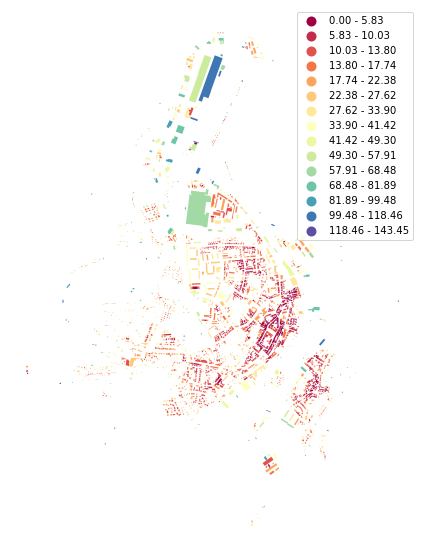

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='neighbour_dist', scheme='naturalbreaks', k=15, legend=True, cmap='Spectral')
ax.set_axis_off()
plt.show()

## Higher order / distance

However, typical usage of spatial weights is to capture the vicinity of each feature. As illustrated in the [previous notebook](weights_nb), there are multiple options on how to capture it. In this example, we will use queen contiguity of the higher order (3) based on morphological tessellation.

In [6]:
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

### Average character

Mean value of selected character within a vicinity of each cell (or building, plot) is a simple example. `AverageCharacter` defaults to mean:

In [7]:
areas = momepy.Area(tessellation).series
mean_area = momepy.AverageCharacter(
    tessellation, values=areas, spatial_weights=sw3, unique_id='uID')
tessellation['mean_area'] = mean_area.series

  0%|          | 0/2518 [00:00<?, ?it/s]

  3%|▎         | 72/2518 [00:00<00:03, 719.60it/s]

  5%|▌         | 132/2518 [00:00<00:03, 676.81it/s]

  7%|▋         | 180/2518 [00:00<00:03, 598.32it/s]

 10%|▉         | 242/2518 [00:00<00:03, 602.93it/s]

 13%|█▎        | 323/2518 [00:00<00:03, 652.16it/s]

 16%|█▌        | 403/2518 [00:00<00:03, 690.33it/s]

 19%|█▉        | 481/2518 [00:00<00:02, 713.25it/s]

 22%|██▏       | 562/2518 [00:00<00:02, 738.60it/s]

 25%|██▌       | 640/2518 [00:00<00:02, 749.45it/s]

 29%|██▉       | 724/2518 [00:01<00:02, 773.60it/s]

 32%|███▏      | 805/2518 [00:01<00:02, 782.42it/s]

 35%|███▌      | 883/2518 [00:01<00:02, 773.95it/s]

 38%|███▊      | 968/2518 [00:01<00:01, 795.07it/s]

 42%|████▏     | 1055/2518 [00:01<00:01, 814.46it/s]

 45%|████▌     | 1143/2518 [00:01<00:01, 829.94it/s]

 49%|████▊     | 1227/2518 [00:01<00:01, 816.99it/s]

 52%|█████▏    | 1309/2518 [00:01<00:01, 720.99it/s]

 55%|█████▌    | 1386/2518 [00:01<00:01, 726.64it/s]

 58%|█████▊    | 1461/2518 [00:01<00:01, 688.93it/s]

 61%|██████    | 1542/2518 [00:02<00:01, 719.20it/s]

 65%|██████▍   | 1632/2518 [00:02<00:01, 765.31it/s]

 68%|██████▊   | 1711/2518 [00:02<00:01, 770.49it/s]

 71%|███████▏  | 1795/2518 [00:02<00:00, 790.08it/s]

 75%|███████▍  | 1881/2518 [00:02<00:00, 809.67it/s]

 78%|███████▊  | 1965/2518 [00:02<00:00, 817.55it/s]

 81%|████████▏ | 2048/2518 [00:02<00:00, 804.66it/s]

 85%|████████▍ | 2132/2518 [00:02<00:00, 812.82it/s]

 88%|████████▊ | 2218/2518 [00:02<00:00, 824.51it/s]

 92%|█████████▏| 2304/2518 [00:03<00:00, 832.30it/s]

 95%|█████████▍| 2388/2518 [00:03<00:00, 809.16it/s]

 98%|█████████▊| 2470/2518 [00:03<00:00, 788.09it/s]

100%|██████████| 2518/2518 [00:03<00:00, 767.27it/s]

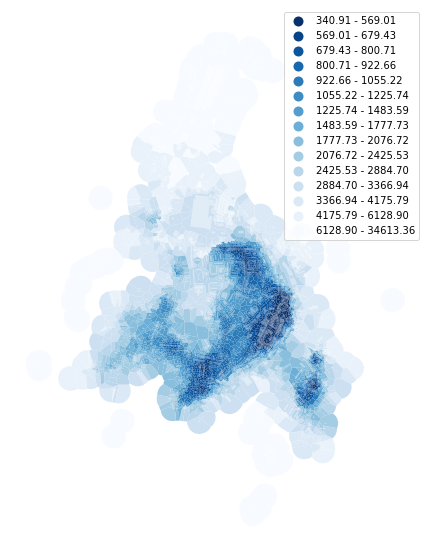

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='mean_area', legend=True, scheme='quantiles', k=15, cmap='Blues_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

In some cases, we might want to eliminate the effect of outliers. To do so, we can specify the range on which should `AverageCharacter` calculate mean. Below we will measure only interquartile mean.

In [9]:
tessellation['mean_area_iq'] = momepy.AverageCharacter(
    tessellation, areas, sw3, 'uID', rng=(25, 75)).series

  0%|          | 0/2518 [00:00<?, ?it/s]

  3%|▎         | 71/2518 [00:00<00:03, 702.20it/s]

  6%|▌         | 146/2518 [00:00<00:03, 714.23it/s]

  9%|▊         | 220/2518 [00:00<00:03, 720.10it/s]

 11%|█         | 277/2518 [00:00<00:03, 663.61it/s]

 13%|█▎        | 338/2518 [00:00<00:03, 645.54it/s]

 16%|█▌        | 404/2518 [00:00<00:03, 649.51it/s]

 19%|█▉        | 473/2518 [00:00<00:03, 657.77it/s]

 21%|██▏       | 539/2518 [00:00<00:03, 658.03it/s]

 24%|██▍       | 611/2518 [00:00<00:02, 673.18it/s]

 27%|██▋       | 679/2518 [00:01<00:02, 673.98it/s]

 30%|██▉       | 746/2518 [00:01<00:02, 670.39it/s]

 33%|███▎      | 823/2518 [00:01<00:02, 695.48it/s]

 36%|███▌      | 901/2518 [00:01<00:02, 718.72it/s]

 39%|███▊      | 973/2518 [00:01<00:02, 696.52it/s]

 41%|████▏     | 1043/2518 [00:01<00:02, 657.03it/s]

 44%|████▍     | 1117/2518 [00:01<00:02, 679.79it/s]

 47%|████▋     | 1192/2518 [00:01<00:01, 699.16it/s]

 50%|█████     | 1263/2518 [00:01<00:01, 681.85it/s]

 53%|█████▎    | 1332/2518 [00:01<00:01, 647.58it/s]

 56%|█████▌    | 1409/2518 [00:02<00:01, 678.31it/s]

 59%|█████▊    | 1478/2518 [00:02<00:01, 642.61it/s]

 61%|██████▏   | 1544/2518 [00:02<00:01, 568.17it/s]

 64%|██████▎   | 1604/2518 [00:02<00:01, 562.35it/s]

 66%|██████▋   | 1672/2518 [00:02<00:01, 592.95it/s]

 69%|██████▉   | 1733/2518 [00:02<00:01, 575.50it/s]

 71%|███████   | 1792/2518 [00:02<00:01, 555.43it/s]

 74%|███████▍  | 1859/2518 [00:02<00:01, 585.35it/s]

 76%|███████▌  | 1919/2518 [00:02<00:01, 581.00it/s]

 79%|███████▉  | 1993/2518 [00:03<00:00, 619.43it/s]

 82%|████████▏ | 2063/2518 [00:03<00:00, 639.65it/s]

 85%|████████▍ | 2140/2518 [00:03<00:00, 672.10it/s]

 88%|████████▊ | 2217/2518 [00:03<00:00, 697.80it/s]

 91%|█████████ | 2291/2518 [00:03<00:00, 708.95it/s]

 94%|█████████▍| 2363/2518 [00:03<00:00, 694.28it/s]

 97%|█████████▋| 2434/2518 [00:03<00:00, 677.59it/s]

 99%|█████████▉| 2505/2518 [00:03<00:00, 685.93it/s]

100%|██████████| 2518/2518 [00:03<00:00, 657.95it/s]

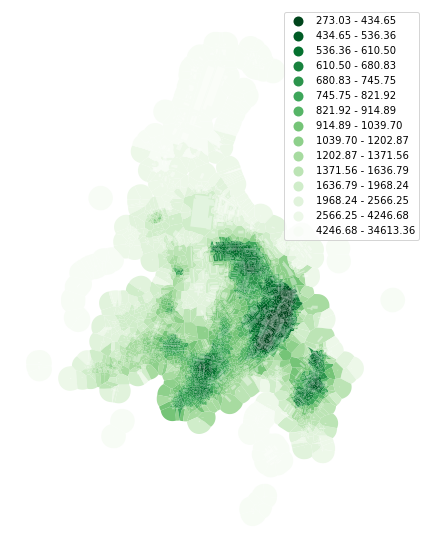

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='mean_area_iq', legend=True, scheme='quantiles', k=15, cmap='Greens_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

Another option would be to calculate median:

In [11]:
tessellation['med_area'] = momepy.AverageCharacter(
    tessellation, areas, sw3, 'uID', mode='median').series

  0%|          | 0/2518 [00:00<?, ?it/s]

  3%|▎         | 80/2518 [00:00<00:03, 791.61it/s]

  7%|▋         | 169/2518 [00:00<00:02, 816.80it/s]

 10%|█         | 260/2518 [00:00<00:02, 841.26it/s]

 14%|█▍        | 348/2518 [00:00<00:02, 851.95it/s]

 16%|█▋        | 415/2518 [00:00<00:02, 743.56it/s]

 20%|█▉        | 496/2518 [00:00<00:02, 761.17it/s]

 23%|██▎       | 579/2518 [00:00<00:02, 780.36it/s]

 26%|██▋       | 664/2518 [00:00<00:02, 798.26it/s]

 30%|██▉       | 754/2518 [00:00<00:02, 825.31it/s]

 33%|███▎      | 842/2518 [00:01<00:01, 839.04it/s]

 37%|███▋      | 931/2518 [00:01<00:01, 851.28it/s]

 40%|████      | 1016/2518 [00:01<00:01, 848.60it/s]

 44%|████▎     | 1101/2518 [00:01<00:01, 751.47it/s]

 47%|████▋     | 1178/2518 [00:01<00:01, 674.67it/s]

 50%|████▉     | 1250/2518 [00:01<00:01, 687.43it/s]

 53%|█████▎    | 1322/2518 [00:01<00:01, 694.38it/s]

 55%|█████▌    | 1393/2518 [00:01<00:01, 666.57it/s]

 58%|█████▊    | 1468/2518 [00:01<00:01, 687.53it/s]

 61%|██████    | 1538/2518 [00:02<00:01, 677.51it/s]

 64%|██████▍   | 1622/2518 [00:02<00:01, 717.54it/s]

 68%|██████▊   | 1711/2518 [00:02<00:01, 761.68it/s]

 71%|███████▏  | 1798/2518 [00:02<00:00, 789.09it/s]

 75%|███████▍  | 1879/2518 [00:02<00:00, 761.27it/s]

 78%|███████▊  | 1957/2518 [00:02<00:00, 738.03it/s]

 81%|████████  | 2032/2518 [00:02<00:00, 729.74it/s]

 84%|████████▍ | 2118/2518 [00:02<00:00, 764.17it/s]

 88%|████████▊ | 2209/2518 [00:02<00:00, 801.01it/s]

 91%|█████████▏| 2298/2518 [00:02<00:00, 825.35it/s]

 95%|█████████▍| 2387/2518 [00:03<00:00, 841.39it/s]

 98%|█████████▊| 2472/2518 [00:03<00:00, 810.58it/s]

100%|██████████| 2518/2518 [00:03<00:00, 774.48it/s]

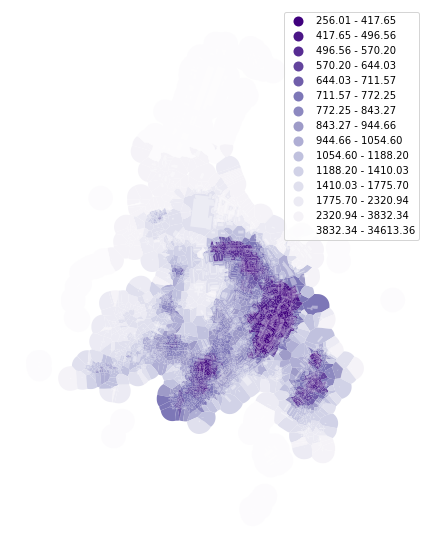

In [12]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='med_area', legend=True, scheme='quantiles', k=15, cmap='Purples_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

### Weighted character

The weighted average is another example using the same spatial weights. For illustration, we can try area-weighted circular compactness:

In [13]:
circular_compactness = momepy.CircularCompactness(buildings)
buildings['weighted_circom'] = momepy.WeightedCharacter(
    buildings, circular_compactness.series, sw3, 'uID', momepy.Area(buildings).series).series

  0%|          | 0/2518 [00:00<?, ?it/s]

  3%|▎         | 77/2518 [00:00<00:03, 762.10it/s]

  6%|▌         | 141/2518 [00:00<00:03, 720.04it/s]

  8%|▊         | 213/2518 [00:00<00:03, 719.74it/s]

 11%|█▏        | 289/2518 [00:00<00:03, 728.95it/s]

 15%|█▍        | 367/2518 [00:00<00:02, 742.11it/s]

 18%|█▊        | 445/2518 [00:00<00:02, 750.72it/s]

 21%|██        | 521/2518 [00:00<00:02, 752.40it/s]

 24%|██▍       | 599/2518 [00:00<00:02, 758.71it/s]

 27%|██▋       | 676/2518 [00:00<00:02, 760.51it/s]

 30%|██▉       | 752/2518 [00:01<00:02, 759.77it/s]

 33%|███▎      | 829/2518 [00:01<00:02, 761.63it/s]

 36%|███▌      | 904/2518 [00:01<00:02, 687.86it/s]

 39%|███▊      | 974/2518 [00:01<00:02, 687.11it/s]

 42%|████▏     | 1048/2518 [00:01<00:02, 701.97it/s]

 45%|████▍     | 1123/2518 [00:01<00:01, 714.15it/s]

 48%|████▊     | 1201/2518 [00:01<00:01, 730.19it/s]

 51%|█████     | 1281/2518 [00:01<00:01, 749.67it/s]

 54%|█████▍    | 1357/2518 [00:01<00:01, 740.45it/s]

 57%|█████▋    | 1435/2518 [00:01<00:01, 751.44it/s]

 60%|██████    | 1514/2518 [00:02<00:01, 761.37it/s]

 63%|██████▎   | 1591/2518 [00:02<00:01, 734.92it/s]

 66%|██████▌   | 1668/2518 [00:02<00:01, 744.00it/s]

 69%|██████▉   | 1746/2518 [00:02<00:01, 752.99it/s]

 72%|███████▏  | 1822/2518 [00:02<00:00, 753.02it/s]

 75%|███████▌  | 1900/2518 [00:02<00:00, 758.07it/s]

 78%|███████▊  | 1976/2518 [00:02<00:00, 717.49it/s]

 81%|████████▏ | 2052/2518 [00:02<00:00, 727.41it/s]

 85%|████████▍ | 2131/2518 [00:02<00:00, 743.21it/s]

 88%|████████▊ | 2206/2518 [00:03<00:00, 720.62it/s]

 91%|█████████ | 2279/2518 [00:03<00:00, 682.09it/s]

 94%|█████████▎| 2357/2518 [00:03<00:00, 707.00it/s]

 97%|█████████▋| 2432/2518 [00:03<00:00, 716.71it/s]

100%|█████████▉| 2509/2518 [00:03<00:00, 731.39it/s]

100%|██████████| 2518/2518 [00:03<00:00, 732.57it/s]

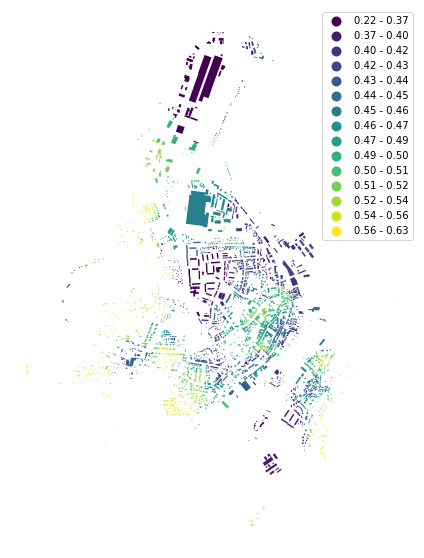

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='weighted_circom', legend=True, scheme='quantiles', k=15, cmap='viridis')
ax.set_axis_off()
plt.show()

### Density

We will again use our Manhattan case study to illustrate `Density`.

In [15]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.footprints.footprints_from_point(point=point, distance=dist)
gdf_projected = ox.project_gdf(gdf)

buildings = momepy.preprocess(gdf_projected, size=30,
                              compactness=True, islands=True)
buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

Loop 1 out of 2.


Identifying changes:   0%|          | 0/3201 [00:00<?, ?it/s]

Identifying changes:  11%|█         | 346/3201 [00:00<00:00, 3456.34it/s]

Identifying changes:  24%|██▎       | 753/3201 [00:00<00:00, 3620.06it/s]

Identifying changes:  36%|███▌      | 1152/3201 [00:00<00:00, 3722.33it/s]

Identifying changes:  46%|████▌     | 1460/3201 [00:00<00:00, 3503.06it/s]

Identifying changes:  58%|█████▊    | 1857/3201 [00:00<00:00, 3623.08it/s]

Identifying changes:  69%|██████▉   | 2211/3201 [00:00<00:00, 3597.22it/s]

Identifying changes:  83%|████████▎ | 2660/3201 [00:00<00:00, 3824.62it/s]

Identifying changes:  97%|█████████▋| 3108/3201 [00:00<00:00, 3999.35it/s]

Identifying changes: 100%|██████████| 3201/3201 [00:00<00:00, 3893.13it/s]


Changing geometry:   0%|          | 0/20 [00:00<?, ?it/s]

Changing geometry:  35%|███▌      | 7/20 [00:00<00:00, 69.46it/s]

Changing geometry:  80%|████████  | 16/20 [00:00<00:00, 73.18it/s]

Changing geometry: 100%|██████████| 20/20 [00:00<00:00, 77.26it/s]

Loop 2 out of 2.


Identifying changes:   0%|          | 0/3168 [00:00<?, ?it/s]

Identifying changes:  14%|█▍        | 457/3168 [00:00<00:00, 4544.55it/s]

Identifying changes:  30%|███       | 958/3168 [00:00<00:00, 4671.74it/s]

Identifying changes:  46%|████▌     | 1449/3168 [00:00<00:00, 4739.13it/s]

Identifying changes:  58%|█████▊    | 1839/3168 [00:00<00:00, 4449.02it/s]

Identifying changes:  70%|███████   | 2226/3168 [00:00<00:00, 4254.97it/s]

Identifying changes:  85%|████████▌ | 2696/3168 [00:00<00:00, 4378.35it/s]

Identifying changes:  99%|█████████▉| 3151/3168 [00:00<00:00, 4427.81it/s]

Identifying changes: 100%|██████████| 3168/3168 [00:00<00:00, 4484.41it/s]


Changing geometry:   0%|          | 0/2 [00:00<?, ?it/s]

Changing geometry: 100%|██████████| 2/2 [00:00<00:00, 75.40it/s]

Inward offset...


Discretization...


  0%|          | 0/3166 [00:00<?, ?it/s]

  1%|          | 21/3166 [00:00<00:15, 207.66it/s]

Generating input point array...


  2%|▏         | 77/3166 [00:00<00:12, 255.79it/s]

  3%|▎         | 100/3166 [00:00<00:14, 215.03it/s]

  4%|▍         | 132/3166 [00:00<00:13, 228.90it/s]

  6%|▌         | 185/3166 [00:00<00:10, 275.33it/s]

  7%|▋         | 226/3166 [00:00<00:09, 305.37it/s]

  8%|▊         | 269/3166 [00:00<00:08, 331.01it/s]

 10%|▉         | 307/3166 [00:00<00:08, 341.83it/s]

 11%|█         | 346/3166 [00:00<00:07, 354.55it/s]

 12%|█▏        | 391/3166 [00:01<00:07, 376.96it/s]

 14%|█▎        | 434/3166 [00:01<00:07, 389.00it/s]

 15%|█▌        | 475/3166 [00:01<00:06, 392.82it/s]

 16%|█▋        | 516/3166 [00:01<00:06, 385.02it/s]

 18%|█▊        | 556/3166 [00:01<00:06, 385.05it/s]

 19%|█▉        | 614/3166 [00:01<00:05, 428.04it/s]

 21%|██▏       | 673/3166 [00:01<00:05, 465.61it/s]

 23%|██▎       | 728/3166 [00:01<00:05, 485.97it/s]

 25%|██▍       | 779/3166 [00:01<00:05, 469.79it/s]

 26%|██▌       | 828/3166 [00:02<00:06, 376.76it/s]

 28%|██▊       | 875/3166 [00:02<00:05, 397.17it/s]

 29%|██▉       | 918/3166 [00:02<00:09, 231.16it/s]

 30%|███       | 952/3166 [00:02<00:09, 245.27it/s]

 31%|███▏      | 991/3166 [00:02<00:07, 275.07it/s]

 33%|███▎      | 1031/3166 [00:02<00:07, 301.22it/s]

 34%|███▎      | 1067/3166 [00:03<00:06, 309.35it/s]

 35%|███▍      | 1102/3166 [00:03<00:06, 318.44it/s]

 36%|███▌      | 1141/3166 [00:03<00:06, 336.24it/s]

 37%|███▋      | 1179/3166 [00:03<00:05, 347.60it/s]

 39%|███▉      | 1248/3166 [00:03<00:04, 407.61it/s]

 41%|████      | 1305/3166 [00:03<00:04, 445.01it/s]

 43%|████▎     | 1358/3166 [00:03<00:03, 464.97it/s]

 44%|████▍     | 1408/3166 [00:03<00:04, 374.86it/s]

 46%|████▌     | 1451/3166 [00:03<00:04, 354.56it/s]

 47%|████▋     | 1491/3166 [00:04<00:06, 269.47it/s]

 48%|████▊     | 1524/3166 [00:04<00:11, 137.36it/s]

 49%|████▉     | 1557/3166 [00:04<00:09, 166.39it/s]

 50%|█████     | 1594/3166 [00:04<00:08, 196.37it/s]

 51%|█████▏    | 1624/3166 [00:05<00:07, 207.62it/s]

 52%|█████▏    | 1661/3166 [00:05<00:06, 237.59it/s]

 55%|█████▍    | 1726/3166 [00:05<00:04, 292.88it/s]

 57%|█████▋    | 1790/3166 [00:05<00:03, 348.85it/s]

 58%|█████▊    | 1838/3166 [00:05<00:03, 370.34it/s]

 60%|█████▉    | 1884/3166 [00:05<00:03, 390.06it/s]

 61%|██████    | 1930/3166 [00:05<00:03, 393.40it/s]

 62%|██████▏   | 1974/3166 [00:05<00:03, 300.67it/s]

 64%|██████▎   | 2011/3166 [00:06<00:03, 297.83it/s]

 66%|██████▌   | 2079/3166 [00:06<00:03, 358.09it/s]

 68%|██████▊   | 2141/3166 [00:06<00:02, 408.81it/s]

 69%|██████▉   | 2191/3166 [00:06<00:02, 338.37it/s]

 71%|███████   | 2254/3166 [00:06<00:02, 392.93it/s]

 73%|███████▎  | 2303/3166 [00:06<00:02, 331.83it/s]

 74%|███████▍  | 2352/3166 [00:06<00:02, 367.37it/s]

 76%|███████▌  | 2396/3166 [00:06<00:02, 374.68it/s]

 78%|███████▊  | 2454/3166 [00:07<00:01, 418.70it/s]

 80%|███████▉  | 2517/3166 [00:07<00:01, 463.86it/s]

 81%|████████  | 2570/3166 [00:07<00:01, 480.53it/s]

 83%|████████▎ | 2641/3166 [00:07<00:00, 531.14it/s]

 85%|████████▌ | 2699/3166 [00:07<00:00, 533.21it/s]

 87%|████████▋ | 2756/3166 [00:07<00:00, 520.36it/s]

 89%|████████▉ | 2811/3166 [00:07<00:00, 522.46it/s]

 91%|█████████ | 2866/3166 [00:07<00:00, 529.14it/s]

 92%|█████████▏| 2920/3166 [00:07<00:00, 525.11it/s]

 94%|█████████▍| 2975/3166 [00:07<00:00, 531.39it/s]

 96%|█████████▌| 3029/3166 [00:08<00:00, 513.06it/s]

 97%|█████████▋| 3081/3166 [00:08<00:00, 292.72it/s]

 99%|█████████▊| 3122/3166 [00:08<00:00, 281.24it/s]

100%|█████████▉| 3159/3166 [00:08<00:00, 299.91it/s]

100%|██████████| 3166/3166 [00:08<00:00, 361.35it/s]

Generating Voronoi diagram...


Generating GeoDataFrame...


Vertices to Polygons:   0%|          | 0/497117 [00:00<?, ?it/s]

Vertices to Polygons:   0%|          | 2301/497117 [00:00<00:21, 23005.20it/s]

Vertices to Polygons:   1%|          | 5574/497117 [00:00<00:19, 25254.82it/s]

Vertices to Polygons:   2%|▏         | 9280/497117 [00:00<00:17, 27922.81it/s]

Vertices to Polygons:   3%|▎         | 12991/497117 [00:00<00:16, 30162.04it/s]

Vertices to Polygons:   3%|▎         | 16683/497117 [00:00<00:15, 31914.49it/s]

Vertices to Polygons:   4%|▍         | 20406/497117 [00:00<00:14, 33341.39it/s]

Vertices to Polygons:   5%|▍         | 24668/497117 [00:00<00:13, 35670.50it/s]

Vertices to Polygons:   6%|▌         | 28166/497117 [00:01<00:25, 18691.60it/s]

Vertices to Polygons:   6%|▋         | 31942/497117 [00:01<00:21, 22028.88it/s]

Vertices to Polygons:   7%|▋         | 35934/497117 [00:01<00:18, 25450.79it/s]

Vertices to Polygons:   8%|▊         | 39859/497117 [00:01<00:16, 28451.02it/s]

Vertices to Polygons:   9%|▉         | 44284/497117 [00:01<00:14, 31862.79it/s]

Vertices to Polygons:  10%|▉         | 48063/497117 [00:01<00:13, 32861.08it/s]

Vertices to Polygons:  10%|█         | 51862/497117 [00:01<00:13, 34246.27it/s]

Vertices to Polygons:  11%|█         | 55598/497117 [00:01<00:12, 34549.74it/s]

Vertices to Polygons:  12%|█▏        | 59690/497117 [00:01<00:12, 36240.64it/s]

Vertices to Polygons:  13%|█▎        | 63820/497117 [00:02<00:11, 37621.97it/s]

Vertices to Polygons:  14%|█▎        | 67786/497117 [00:02<00:11, 38210.92it/s]

Vertices to Polygons:  14%|█▍        | 71873/497117 [00:02<00:10, 38970.93it/s]

Vertices to Polygons:  15%|█▌        | 76291/497117 [00:02<00:10, 40398.40it/s]

Vertices to Polygons:  16%|█▌        | 80395/497117 [00:02<00:10, 40195.19it/s]

Vertices to Polygons:  17%|█▋        | 84816/497117 [00:02<00:09, 41318.73it/s]

Vertices to Polygons:  18%|█▊        | 88988/497117 [00:02<00:10, 40799.94it/s]

Vertices to Polygons:  19%|█▊        | 93097/497117 [00:02<00:10, 38689.48it/s]

Vertices to Polygons:  20%|█▉        | 97642/497117 [00:02<00:09, 40496.17it/s]

Vertices to Polygons:  21%|██        | 102221/497117 [00:02<00:09, 41948.05it/s]

Vertices to Polygons:  22%|██▏       | 106939/497117 [00:03<00:08, 43390.19it/s]

Vertices to Polygons:  22%|██▏       | 111326/497117 [00:03<00:09, 42644.36it/s]

Vertices to Polygons:  23%|██▎       | 115627/497117 [00:03<00:09, 41609.95it/s]

Vertices to Polygons:  24%|██▍       | 120314/497117 [00:03<00:08, 43057.17it/s]

Vertices to Polygons:  25%|██▌       | 124692/497117 [00:03<00:08, 43270.60it/s]

Vertices to Polygons:  26%|██▌       | 129444/497117 [00:03<00:08, 44463.04it/s]

Vertices to Polygons:  27%|██▋       | 133916/497117 [00:03<00:08, 43436.92it/s]

Vertices to Polygons:  28%|██▊       | 138283/497117 [00:03<00:08, 43329.28it/s]

Vertices to Polygons:  29%|██▊       | 142633/497117 [00:03<00:08, 40313.72it/s]

Vertices to Polygons:  30%|██▉       | 146718/497117 [00:03<00:08, 40323.54it/s]

Vertices to Polygons:  30%|███       | 150788/497117 [00:04<00:09, 38329.36it/s]

Vertices to Polygons:  31%|███       | 154668/497117 [00:04<00:08, 38130.81it/s]

Vertices to Polygons:  32%|███▏      | 158515/497117 [00:04<00:08, 37990.69it/s]

Vertices to Polygons:  33%|███▎      | 162338/497117 [00:04<00:08, 37738.56it/s]

Vertices to Polygons:  34%|███▎      | 166969/497117 [00:04<00:08, 39956.32it/s]

Vertices to Polygons:  34%|███▍      | 171221/497117 [00:04<00:08, 40691.32it/s]

Vertices to Polygons:  35%|███▌      | 175327/497117 [00:04<00:08, 39288.93it/s]

Vertices to Polygons:  36%|███▌      | 179614/497117 [00:04<00:07, 40296.66it/s]

Vertices to Polygons:  37%|███▋      | 183676/497117 [00:04<00:07, 39280.72it/s]

Vertices to Polygons:  38%|███▊      | 187632/497117 [00:05<00:08, 38147.87it/s]

Vertices to Polygons:  39%|███▊      | 191474/497117 [00:05<00:08, 37997.28it/s]

Vertices to Polygons:  39%|███▉      | 195293/497117 [00:05<00:08, 37532.49it/s]

Vertices to Polygons:  40%|████      | 199061/497117 [00:05<00:07, 37308.73it/s]

Vertices to Polygons:  41%|████      | 202803/497117 [00:05<00:07, 36860.14it/s]

Vertices to Polygons:  42%|████▏     | 206922/497117 [00:05<00:07, 38060.11it/s]

Vertices to Polygons:  42%|████▏     | 210779/497117 [00:05<00:07, 38210.86it/s]

Vertices to Polygons:  43%|████▎     | 214612/497117 [00:05<00:07, 38139.07it/s]

Vertices to Polygons:  44%|████▍     | 218434/497117 [00:05<00:07, 37790.51it/s]

Vertices to Polygons:  45%|████▍     | 222775/497117 [00:05<00:06, 39316.24it/s]

Vertices to Polygons:  46%|████▌     | 227193/497117 [00:06<00:06, 40659.06it/s]

Vertices to Polygons:  47%|████▋     | 231594/497117 [00:06<00:06, 41609.41it/s]

Vertices to Polygons:  47%|████▋     | 235779/497117 [00:06<00:06, 40270.95it/s]

Vertices to Polygons:  48%|████▊     | 239895/497117 [00:06<00:06, 40533.36it/s]

Vertices to Polygons:  49%|████▉     | 244331/497117 [00:06<00:06, 41609.14it/s]

Vertices to Polygons:  50%|████▉     | 248512/497117 [00:06<00:06, 40321.73it/s]

Vertices to Polygons:  51%|█████     | 252567/497117 [00:06<00:06, 40382.70it/s]

Vertices to Polygons:  52%|█████▏    | 256917/497117 [00:06<00:05, 41269.51it/s]

Vertices to Polygons:  53%|█████▎    | 261060/497117 [00:06<00:05, 41064.05it/s]

Vertices to Polygons:  53%|█████▎    | 265178/497117 [00:06<00:05, 40500.83it/s]

Vertices to Polygons:  54%|█████▍    | 269238/497117 [00:07<00:05, 39669.07it/s]

Vertices to Polygons:  55%|█████▌    | 273685/497117 [00:07<00:05, 40995.55it/s]

Vertices to Polygons:  56%|█████▌    | 278058/497117 [00:07<00:05, 41777.84it/s]

Vertices to Polygons:  57%|█████▋    | 282253/497117 [00:07<00:05, 41694.62it/s]

Vertices to Polygons:  58%|█████▊    | 286435/497117 [00:07<00:05, 41069.10it/s]

Vertices to Polygons:  58%|█████▊    | 290553/497117 [00:07<00:05, 39530.49it/s]

Vertices to Polygons:  59%|█████▉    | 294526/497117 [00:07<00:05, 36236.33it/s]

Vertices to Polygons:  60%|██████    | 298781/497117 [00:07<00:05, 37923.62it/s]

Vertices to Polygons:  61%|██████    | 303194/497117 [00:07<00:04, 39592.87it/s]

Vertices to Polygons:  62%|██████▏   | 307220/497117 [00:08<00:04, 39412.42it/s]

Vertices to Polygons:  63%|██████▎   | 311639/497117 [00:08<00:04, 40732.33it/s]

Vertices to Polygons:  64%|██████▎   | 316346/497117 [00:08<00:04, 42444.68it/s]

Vertices to Polygons:  65%|██████▍   | 320722/497117 [00:08<00:04, 42830.13it/s]

Vertices to Polygons:  65%|██████▌   | 325430/497117 [00:08<00:03, 44021.80it/s]

Vertices to Polygons:  66%|██████▋   | 329866/497117 [00:08<00:03, 43745.22it/s]

Vertices to Polygons:  67%|██████▋   | 334265/497117 [00:08<00:03, 43422.33it/s]

Vertices to Polygons:  68%|██████▊   | 338625/497117 [00:08<00:03, 43186.09it/s]

Vertices to Polygons:  69%|██████▉   | 342956/497117 [00:08<00:03, 42082.31it/s]

Vertices to Polygons:  70%|██████▉   | 347179/497117 [00:08<00:03, 40802.27it/s]

Vertices to Polygons:  71%|███████   | 351279/497117 [00:09<00:03, 40029.26it/s]

Vertices to Polygons:  71%|███████▏  | 355299/497117 [00:09<00:03, 38692.56it/s]

Vertices to Polygons:  72%|███████▏  | 359754/497117 [00:09<00:03, 40281.10it/s]

Vertices to Polygons:  73%|███████▎  | 363814/497117 [00:09<00:03, 40062.50it/s]

Vertices to Polygons:  74%|███████▍  | 367843/497117 [00:09<00:03, 39617.15it/s]

Vertices to Polygons:  75%|███████▍  | 371822/497117 [00:09<00:03, 39224.94it/s]

Vertices to Polygons:  76%|███████▌  | 375758/497117 [00:09<00:03, 38371.65it/s]

Vertices to Polygons:  76%|███████▋  | 379837/497117 [00:09<00:03, 39065.49it/s]

Vertices to Polygons:  77%|███████▋  | 384142/497117 [00:09<00:02, 40179.29it/s]

Vertices to Polygons:  78%|███████▊  | 388177/497117 [00:10<00:02, 39275.63it/s]

Vertices to Polygons:  79%|███████▉  | 392148/497117 [00:10<00:02, 39403.75it/s]

Vertices to Polygons:  80%|███████▉  | 396100/497117 [00:10<00:02, 37832.36it/s]

Vertices to Polygons:  81%|████████  | 400528/497117 [00:10<00:02, 39559.84it/s]

Vertices to Polygons:  81%|████████▏ | 404930/497117 [00:10<00:02, 40799.89it/s]

Vertices to Polygons:  82%|████████▏ | 409458/497117 [00:10<00:02, 42046.83it/s]

Vertices to Polygons:  83%|████████▎ | 414103/497117 [00:10<00:01, 43277.08it/s]

Vertices to Polygons:  84%|████████▍ | 418464/497117 [00:10<00:01, 41281.23it/s]

Vertices to Polygons:  85%|████████▌ | 422919/497117 [00:10<00:01, 42209.28it/s]

Vertices to Polygons:  86%|████████▌ | 427252/497117 [00:10<00:01, 42537.49it/s]

Vertices to Polygons:  87%|████████▋ | 431544/497117 [00:11<00:01, 42649.72it/s]

Vertices to Polygons:  88%|████████▊ | 435827/497117 [00:11<00:01, 41821.47it/s]

Vertices to Polygons:  89%|████████▊ | 440048/497117 [00:11<00:01, 41936.42it/s]

Vertices to Polygons:  89%|████████▉ | 444253/497117 [00:11<00:01, 40197.10it/s]

Vertices to Polygons:  90%|█████████ | 448456/497117 [00:11<00:01, 40729.72it/s]

Vertices to Polygons:  91%|█████████ | 453011/497117 [00:11<00:01, 42063.87it/s]

Vertices to Polygons:  92%|█████████▏| 457241/497117 [00:11<00:00, 41799.42it/s]

Vertices to Polygons:  93%|█████████▎| 461438/497117 [00:11<00:00, 41556.21it/s]

Vertices to Polygons:  94%|█████████▎| 465606/497117 [00:11<00:00, 39997.89it/s]

Vertices to Polygons:  95%|█████████▍| 470005/497117 [00:12<00:00, 41117.08it/s]

Vertices to Polygons:  96%|█████████▌| 474801/497117 [00:12<00:00, 42953.54it/s]

Vertices to Polygons:  96%|█████████▋| 479134/497117 [00:12<00:00, 41100.33it/s]

Vertices to Polygons:  97%|█████████▋| 483471/497117 [00:12<00:00, 41754.95it/s]

Vertices to Polygons:  98%|█████████▊| 488059/497117 [00:12<00:00, 42910.02it/s]

Vertices to Polygons:  99%|█████████▉| 492381/497117 [00:12<00:00, 40921.16it/s]

Vertices to Polygons: 100%|█████████▉| 497033/497117 [00:12<00:00, 42452.52it/s]

Vertices to Polygons: 100%|██████████| 497117/497117 [00:12<00:00, 39338.41it/s]

Dissolving Voronoi polygons...


Preparing limit for edge resolving...
Building R-tree...


  0%|          | 0/163 [00:00<?, ?it/s]

 20%|█▉        | 32/163 [00:00<00:00, 303.84it/s]

Identifying edge cells...


 29%|██▉       | 47/163 [00:00<00:00, 227.05it/s]

 36%|███▌      | 58/163 [00:00<00:00, 146.57it/s]

 50%|████▉     | 81/163 [00:00<00:00, 163.57it/s]

 69%|██████▉   | 113/163 [00:00<00:00, 191.05it/s]

 88%|████████▊ | 144/163 [00:00<00:00, 215.18it/s]

100%|██████████| 163/163 [00:00<00:00, 228.17it/s]


  0%|          | 0/95 [00:00<?, ?it/s]

 43%|████▎     | 41/95 [00:00<00:00, 408.22it/s]

Cutting...


 97%|█████████▋| 92/95 [00:00<00:00, 432.31it/s]

100%|██████████| 95/95 [00:00<00:00, 455.86it/s]


/Users/martin/Strathcloud/Personal Folders/momepy/momepy/momepy/elements.py:429: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [833, 1979, 2870, 2875, 3132]
  "unique_id of affected elements: {}".format(list(uids))


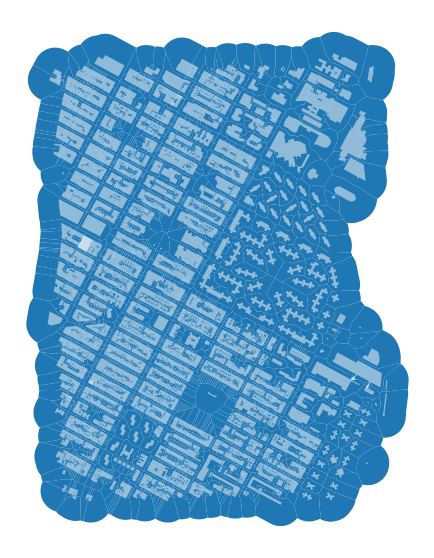

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()


To get gross density, we need to know floor areas:

In [17]:
buildings['height'] = buildings['height'].fillna(0).astype(float)
buildings['floor_area'] = momepy.FloorArea(buildings, 'height').series

Now we merge floor areas to tessellation based on shared unique ID and generate spatial weights.

In [18]:
tessellation = tessellation.merge(buildings[['uID', 'floor_area']])
sw = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

`Density` is then following the same principle as illustrated above.

In [19]:
gross = momepy.Density(
    tessellation, values='floor_area', spatial_weights=sw, unique_id='uID')
tessellation['gross_density'] = gross.series

  0%|          | 0/3166 [00:00<?, ?it/s]

  3%|▎         | 99/3166 [00:00<00:03, 979.44it/s]

  6%|▌         | 189/3166 [00:00<00:03, 953.60it/s]

  9%|▉         | 286/3166 [00:00<00:03, 956.87it/s]

 12%|█▏        | 366/3166 [00:00<00:03, 899.46it/s]

 14%|█▍        | 439/3166 [00:00<00:03, 839.20it/s]

 17%|█▋        | 532/3166 [00:00<00:03, 864.14it/s]

 20%|█▉        | 623/3166 [00:00<00:02, 875.04it/s]

 23%|██▎       | 719/3166 [00:00<00:02, 896.39it/s]

 26%|██▌       | 814/3166 [00:00<00:02, 911.17it/s]

 29%|██▉       | 912/3166 [00:01<00:02, 929.89it/s]

 32%|███▏      | 1010/3166 [00:01<00:02, 941.71it/s]

 35%|███▍      | 1108/3166 [00:01<00:02, 951.82it/s]

 38%|███▊      | 1205/3166 [00:01<00:02, 955.42it/s]

 41%|████      | 1302/3166 [00:01<00:01, 958.60it/s]

 44%|████▍     | 1398/3166 [00:01<00:01, 946.68it/s]

 47%|████▋     | 1497/3166 [00:01<00:01, 957.45it/s]

 50%|█████     | 1596/3166 [00:01<00:01, 965.77it/s]

 53%|█████▎    | 1693/3166 [00:01<00:01, 957.90it/s]

 57%|█████▋    | 1789/3166 [00:01<00:01, 900.08it/s]

 59%|█████▉    | 1881/3166 [00:02<00:01, 904.75it/s]

 62%|██████▏   | 1978/3166 [00:02<00:01, 922.55it/s]

 66%|██████▌   | 2075/3166 [00:02<00:01, 935.81it/s]

 69%|██████▊   | 2172/3166 [00:02<00:01, 943.49it/s]

 72%|███████▏  | 2267/3166 [00:02<00:00, 941.33it/s]

 75%|███████▍  | 2365/3166 [00:02<00:00, 952.03it/s]

 78%|███████▊  | 2462/3166 [00:02<00:00, 955.14it/s]

 81%|████████  | 2558/3166 [00:02<00:00, 956.44it/s]

 84%|████████▍ | 2654/3166 [00:02<00:00, 931.99it/s]

 87%|████████▋ | 2748/3166 [00:02<00:00, 882.92it/s]

 90%|████████▉ | 2845/3166 [00:03<00:00, 907.25it/s]

 93%|█████████▎| 2944/3166 [00:03<00:00, 929.96it/s]

 96%|█████████▌| 3044/3166 [00:03<00:00, 947.93it/s]

 99%|█████████▉| 3140/3166 [00:03<00:00, 935.28it/s]

100%|██████████| 3166/3166 [00:03<00:00, 925.03it/s]

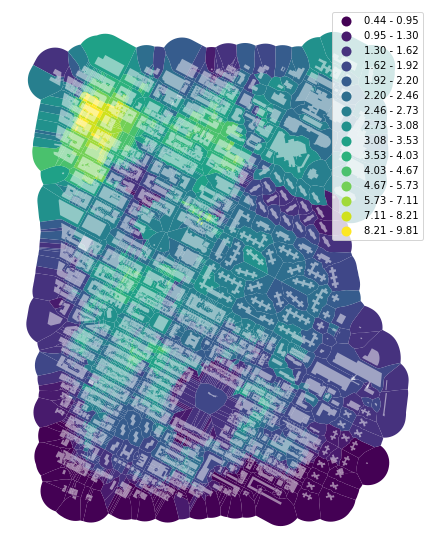

In [20]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='gross_density', legend=True, scheme='naturalbreaks', k=15)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In a similar way can be done gross coverage.

In [21]:
buildings['area'] = momepy.Area(buildings).series
tessellation = tessellation.merge(buildings[['uID', 'area']])

In [22]:
coverage = momepy.Density(
    tessellation, values='area', spatial_weights=sw, unique_id='uID')
tessellation['gross_coverage'] = coverage.series

  0%|          | 0/3166 [00:00<?, ?it/s]

  3%|▎         | 88/3166 [00:00<00:03, 874.88it/s]

  6%|▌         | 185/3166 [00:00<00:03, 899.04it/s]

  9%|▉         | 284/3166 [00:00<00:03, 922.59it/s]

 12%|█▏        | 379/3166 [00:00<00:02, 930.49it/s]

 14%|█▍        | 459/3166 [00:00<00:03, 884.51it/s]

 17%|█▋        | 553/3166 [00:00<00:02, 899.20it/s]

 21%|██        | 650/3166 [00:00<00:02, 918.37it/s]

 24%|██▎       | 747/3166 [00:00<00:02, 931.73it/s]

 27%|██▋       | 840/3166 [00:00<00:02, 929.07it/s]

 29%|██▉       | 932/3166 [00:01<00:02, 925.68it/s]

 32%|███▏      | 1024/3166 [00:01<00:02, 922.07it/s]

 35%|███▌      | 1115/3166 [00:01<00:02, 896.89it/s]

 38%|███▊      | 1204/3166 [00:01<00:02, 862.89it/s]

 41%|████      | 1290/3166 [00:01<00:02, 837.16it/s]

 43%|████▎     | 1374/3166 [00:01<00:02, 767.76it/s]

 46%|████▌     | 1452/3166 [00:01<00:02, 744.52it/s]

 49%|████▊     | 1538/3166 [00:01<00:02, 774.25it/s]

 51%|█████     | 1617/3166 [00:01<00:02, 752.26it/s]

 54%|█████▎    | 1694/3166 [00:02<00:02, 684.88it/s]

 56%|█████▋    | 1785/3166 [00:02<00:01, 739.30it/s]

 59%|█████▉    | 1880/3166 [00:02<00:01, 790.75it/s]

 62%|██████▏   | 1976/3166 [00:02<00:01, 834.82it/s]

 65%|██████▌   | 2071/3166 [00:02<00:01, 866.14it/s]

 68%|██████▊   | 2162/3166 [00:02<00:01, 876.47it/s]

 71%|███████   | 2252/3166 [00:02<00:01, 868.74it/s]

 74%|███████▍  | 2340/3166 [00:02<00:00, 848.15it/s]

 77%|███████▋  | 2426/3166 [00:02<00:00, 846.07it/s]

 79%|███████▉  | 2512/3166 [00:02<00:00, 826.99it/s]

 82%|████████▏ | 2603/3166 [00:03<00:00, 849.25it/s]

 85%|████████▌ | 2695/3166 [00:03<00:00, 867.18it/s]

 88%|████████▊ | 2787/3166 [00:03<00:00, 881.76it/s]

 91%|█████████ | 2881/3166 [00:03<00:00, 895.89it/s]

 94%|█████████▍| 2971/3166 [00:03<00:00, 878.46it/s]

 97%|█████████▋| 3060/3166 [00:03<00:00, 848.88it/s]

 99%|█████████▉| 3146/3166 [00:03<00:00, 837.89it/s]

100%|██████████| 3166/3166 [00:03<00:00, 851.32it/s]

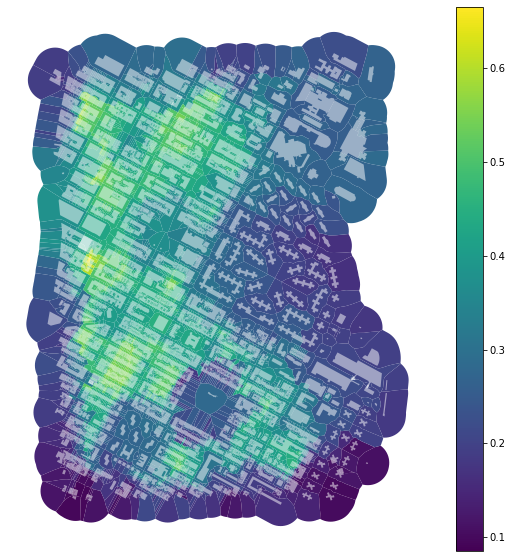

In [23]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='gross_coverage', legend=True)
buildings.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()